In [1]:
import numpy as np # linear algebra
import pandas as pd 
import os

os.listdir('/kaggle/input/brain-tumor-mri-dataset/Training/')

['pituitary', 'notumor', 'meningioma', 'glioma']

In [2]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [3]:
print(len(os.listdir('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/')))
print(len(os.listdir('/kaggle/input/brain-tumor-mri-dataset/Training/notumor/')))
print(len(os.listdir('/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/')))
print(len(os.listdir('/kaggle/input/brain-tumor-mri-dataset/Training/glioma/')))

1457
1595
1339
1321


In [4]:
print(len(os.listdir('/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/')))
print(len(os.listdir('/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/')))
print(len(os.listdir('/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/')))
print(len(os.listdir('/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/')))

300
405
306
300


In [5]:
#importing libraries
import tensorflow
from tensorflow import keras
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet_v2 import MobileNetV2,preprocess_input
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [6]:
import tensorflow 
from keras.models import Sequential 
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator as IDG
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
import seaborn
import torch
from IPython import display 
%config InlineBackend.figure_formats = ['svg']

In [7]:
image = []
label = []
img_width = 64
img_height = 64

for i in os.listdir('/kaggle/input/brain-tumor-mri-dataset/Training/'):
    for j in os.listdir('/kaggle/input/brain-tumor-mri-dataset/Training/'+i):
        img = cv2.imread('/kaggle/input/brain-tumor-mri-dataset/Training/'+i+'/'+j)
        img = cv2.resize(img, (img_height,img_width))
        label.append(i)
        image.append(img)
        
        
        
x = np.array(image)
y = np.array(label)

In [8]:
le = LabelEncoder()
y = le.fit_transform(y)

In [9]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=30,stratify=y)
x_train = x_train/255
x_test = x_test/255
#data preprocessing and data augmentation
train_datagen = IDG(
                   fill_mode='nearest',
                   featurewise_center=True,
                   validation_split=0.2,
                   horizontal_flip=True,
                   vertical_flip= True, 
                   shear_range=0.2,
                   zoom_range=0.2,
                   brightness_range=(0.4,0.6),
                   rotation_range=10,
                   featurewise_std_normalization=True,
                   )
train_datagen.fit(x_train)

In [10]:
from keras import backend as K
from tensorflow.keras.utils import get_custom_objects


def custom_relu(x):
    return K.sigmoid(-x) * 2 - 1

model= keras.Sequential()

model.add(Conv2D(32, (3, 3),activation=custom_relu,input_shape=(64,64,3),name='block1_cov1'))
model.add(Conv2D(32, (3, 3), activation=custom_relu,name='block1_cov2'))
model.add(MaxPooling2D(pool_size=(2, 2),name='block1_pool'))

model.add(Conv2D(64, (3, 3), activation=custom_relu,name='block2_cov1'))
model.add(Conv2D(64, (3, 3), activation=custom_relu,name='block2_cov2'))
model.add(MaxPooling2D(pool_size=(2, 2),name='block2_pool'))

model.add(Conv2D(128, (3, 3), activation=custom_relu,name='block3_cov1'))
model.add(Conv2D(128, (3, 3), activation=custom_relu,name='block3_cov2'))
model.add(Conv2D(128, (3, 3), activation=custom_relu,name='block3_cov3'))
model.add(MaxPooling2D(pool_size=(2, 2),name='block3_pool'))

model.add(GlobalAveragePooling2D(name='global_average_pooling2d'))
model.add(Dense(128, activation = 'relu',name='dense1'))
model.add(Dense(4, activation='softmax',name='dense2'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_cov1 (Conv2D)        (None, 62, 62, 32)        896       
                                                                 
 block1_cov2 (Conv2D)        (None, 60, 60, 32)        9248      
                                                                 
 block1_pool (MaxPooling2D)  (None, 30, 30, 32)        0         
                                                                 
 block2_cov1 (Conv2D)        (None, 28, 28, 64)        18496     
                                                                 
 block2_cov2 (Conv2D)        (None, 26, 26, 64)        36928     
                                                                 
 block2_pool (MaxPooling2D)  (None, 13, 13, 64)        0         
                                                                 
 block3_cov1 (Conv2D)        (None, 11, 11, 128)       7

In [11]:
#compiling the model with adam optimizer
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [12]:
#early fitting the model in order to avoid overfitting 
early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',patience=30,restore_best_weights=True)
FIT =model.fit(x_train,y_train,
    validation_data = (x_test,y_test), 
    epochs=85,
    callbacks = [early],
    verbose = 1,
    shuffle=True,           
    steps_per_epoch=6)

Epoch 1/85
6/6 [==============================] - 44s 7s/step - loss: 1.3737 - accuracy: 0.2793 - val_loss: 1.3703 - val_accuracy: 0.2791
Epoch 2/85
6/6 [==============================] - 42s 7s/step - loss: 1.3567 - accuracy: 0.2793 - val_loss: 1.3260 - val_accuracy: 0.2791
Epoch 3/85
6/6 [==============================] - 42s 7s/step - loss: 1.2964 - accuracy: 0.3224 - val_loss: 1.2028 - val_accuracy: 0.4322
Epoch 4/85
6/6 [==============================] - 43s 7s/step - loss: 1.2025 - accuracy: 0.4209 - val_loss: 1.0934 - val_accuracy: 0.4541
Epoch 5/85
6/6 [==============================] - 44s 7s/step - loss: 1.1827 - accuracy: 0.4189 - val_loss: 1.1427 - val_accuracy: 0.4943
Epoch 6/85
6/6 [==============================] - 43s 7s/step - loss: 1.1287 - accuracy: 0.4865 - val_loss: 1.1256 - val_accuracy: 0.4444
Epoch 7/85
6/6 [==============================] - 43s 7s/step - loss: 1.0992 - accuracy: 0.4833 - val_loss: 1.0470 - val_accuracy: 0.5372
Epoch 8/85
6/6 [==================

In [13]:
#to get the test accuracy
model.evaluate(x_test,y_test)

36/36 [==============================] - 3s 70ms/step - loss: 0.2922 - accuracy: 0.8994


[0.2922425866127014, 0.8993875980377197]

In [14]:
import matplotlib.pyplot as plt

In [15]:
acc = FIT.history['accuracy']
val_acc = FIT.history['val_accuracy']
loss = FIT.history['loss']
val_loss = FIT.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 4))

<Figure size 1600x400 with 0 Axes>

<Figure size 1600x400 with 0 Axes>

Text(0.5, 1.0, 'Training and Validation Accuracy')

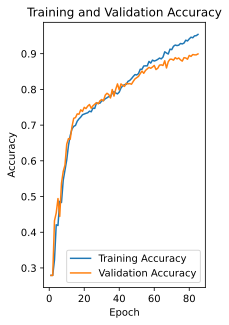

In [16]:
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

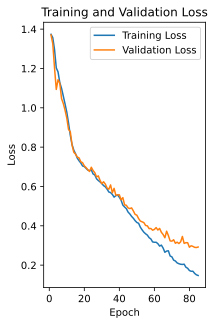

In [17]:
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
y_pred = model.predict(x_test)
y_pred = np.argmax (y_pred, axis = 1)
print(classification_report(y_pred, y_test))

36/36 [==============================] - 3s 66ms/step
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       253
           1       0.85      0.83      0.84       276
           2       0.93      0.95      0.94       314
           3       0.94      0.91      0.93       300

    accuracy                           0.90      1143
   macro avg       0.90      0.90      0.90      1143
weighted avg       0.90      0.90      0.90      1143



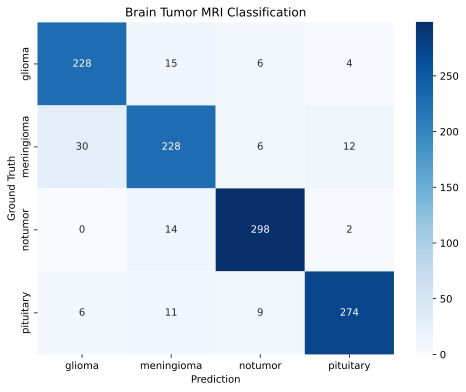

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt

cnf = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

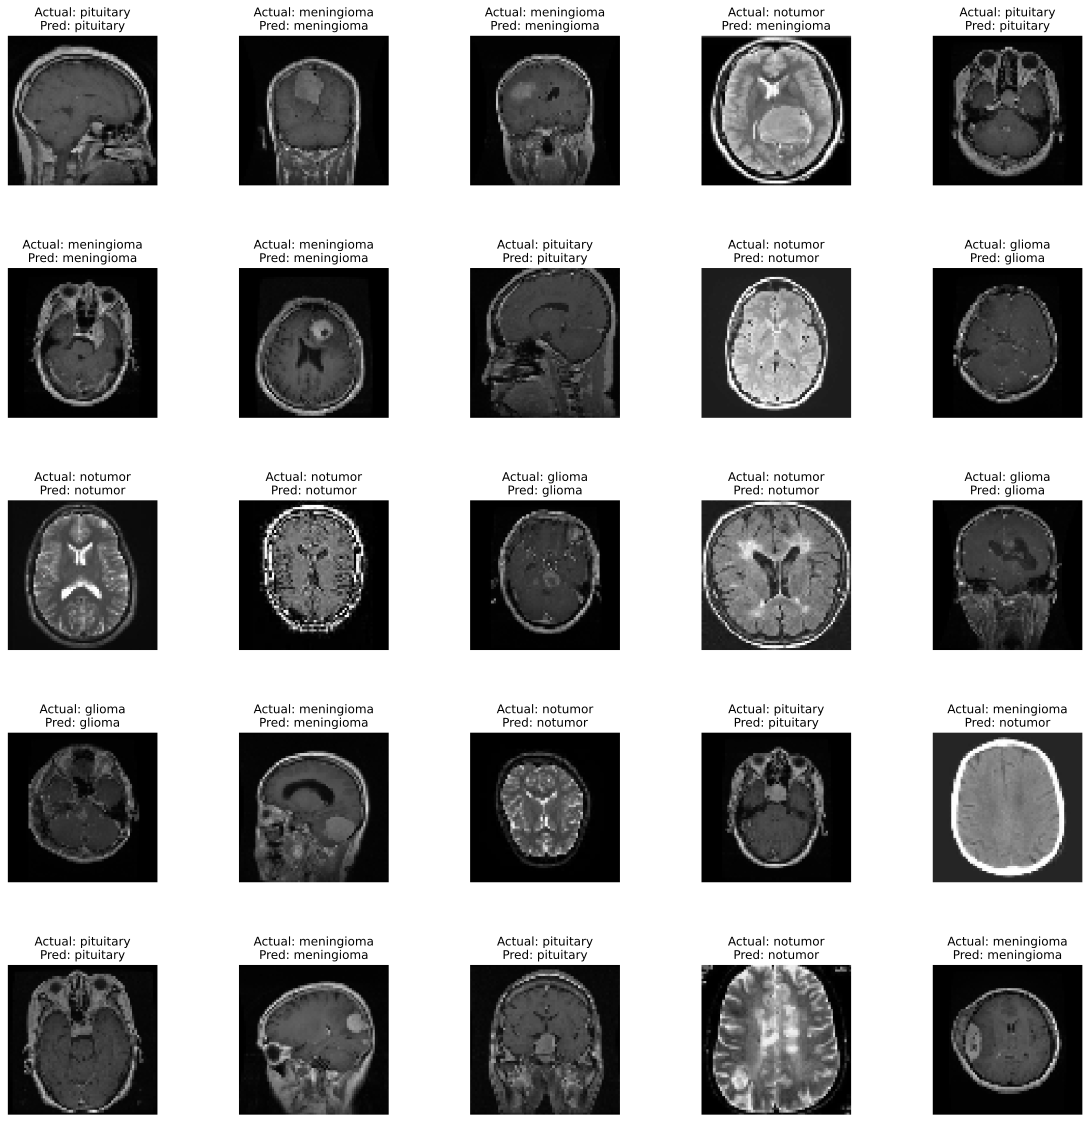

In [20]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = y_pred[img_idx]
        predicted = y_test[img_idx]
       
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: ' + labels[actual] + '\nPred: ' + labels[predicted])  # Corrected line
        ax[i][j].imshow(x_test[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)
